<img src="figures/lwx.png" alt="Logo LWX" title="" style="height:100px" align="right"/>
<img src="figures/logo_IFL.svg" alt="Logo IFL" title="" style="height:100px" align="left"/>

## Entwicklung eines automatisierten Auslegungs- und Optimierungsprogramms für anisotrope UAV-Propeller

### Lukas Hilbers, E-Mail: l.hi@posteo.de
---

## Agenda
- #### Motivation
- #### Herangehensweise
- #### Software-Architektur
- #### Lastenrechnung mit XFOIL und XROTOR
- #### Fe-Modellierung mit PyMAPDL
---

## Motivation
<img src="figures/Helics_Mat_1.jpg" alt="Naturfasern" title="" style="height:400px" align="right"/>

- #### Studienarbeit: Evaluierung naturfaserverstärkter Kunststoffe für Einsatz in Multicopter-Propellern
    * #### FE-Simulationen mit generischem Modell in ANSYS-CLASSIC
    * #### Werkstoffe (insbes. FLAXPREG) prinzipiell geeignet
    * #### Offene Themen: Lastrechnung und Übertragung auf reale Geometrien
    * #### Workflow: Weitgehend händisch, umständlich
- #### Interessengebiete: Optimierung und Programmierung
- #### Idee: Entwicklung einer automatisierten Toolchain zur Auslegung in Python
    * #### PyMAPDL: interaktives Interface zwischen Python und Ansys
    * #### PyOpt: wissenschaftlich fundierte Optimierungs-Toolbox

---

## Lastrechnung

<img src="figures/xfoil_logo.gif" alt="Naturfasern" title="" style="height:100px" align="right"/>

- ### Verwendung von XFOIL und XROTOR
- ### Implementierung eines Python-Interface
    * ### Im Netz nur unbrauchbare oder schlecht dokumentierte Pakete...

#### Eigenes Interface:

<img src="figures/xsoftware.svg" alt="Xsoftware" title="" align="right"/>


```python
from util_loads import Xfoil

polar_file = '_xfoil_polar.txt'

# Das Inputfile wird mit einem Context-Manager generiert und automatisch abgeschickt:

with Xfoil() as x:
    x.run('aero')
    #...
    x.run('quit')
    
# Outputfiles werden mit statischen Methoden eingelesen

polar = Xfoil.read_polar(polar_file)
```

---

## Lastrechnungs-Package für Propeller:

<img src="figures/util_loads.svg" alt="util_loads" title="" align="right"/>

- ### Basis: XFOIL und XROTOR 
- ### Verwendung beliebiger Profile und Grundrisse
- ### Auswertung verschiedener Lastfälle und Bildung einhüllender Lastverläufe

In [7]:
# Third-Party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Local imports
from util_loads import Propeller, Airfoil, Loadcase

# Define Airfoil
airfoil = Airfoil('mf3218.xfo', 500000, iter_limit=600)

# Instantiate Propeller and assign geometry and airfoils

propeller = Propeller(number_of_blades=2,
                      tip_radius=0.412,
                      hub_radius=0.04,
                      )

#                              [r/R, c/R, beta]
propeller.geometry = np.array([[0.10,0.078,0],
                               [0.121, 0.078, 0.],
                               [0.155, 0.100, 5.99],
                               [0.223, 0.160, 17.97],
                               [0.345, 0.149, 14.44],
                               [0.417, 0.142, 12.68],
                               [0.490, 0.135, 11.18],
                               [0.563, 0.128, 9.94],
                               [0.636, 0.121, 8.97],
                               [0.709, 0.114, 8.26],
                               [0.782, 0.107, 7.81],
                               [0.854, 0.100, 7.63],
                               [0.947, 0.091, 7.5],
                               [1., 0.066, 7.5],                               
                               ])

propeller.sections = [[0.121, airfoil],
                      [1., airfoil],]

In [8]:
# Calculate polar
airfoil.set_polar(alpha_start=-20, alpha_stop=20, alpha_inc=0.25)

# Instantiate Loadcases
propeller.add_loadcase(loadcase=Loadcase(name='Max RPM', flight_speed=0.01))
propeller.loadcases[0][0].set_data('rpm',4000)

# Calculate loads
propeller.calc_loads()
propeller.set_load_envelope()

Text(0, 0.5, 'CL / 1')

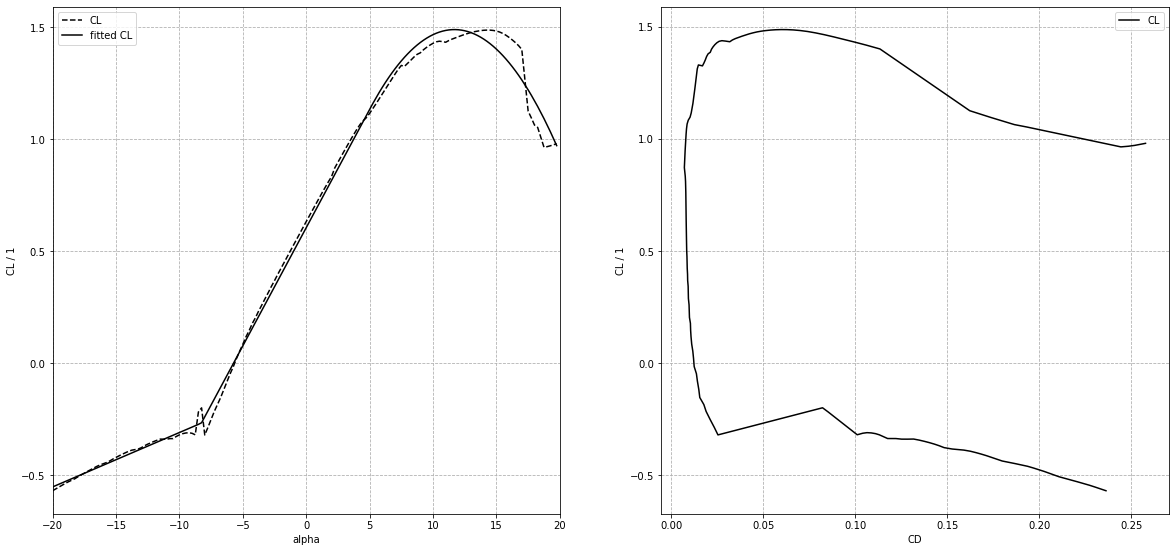

In [40]:
fig_polar, ax_polar = plt.subplots(1, 2, figsize=(20, 10))

datasets = [['CL', 'black', 'dashed'],
            ['fitted CL', 'black', 'solid'],] 

for dataset in datasets:
    airfoil.polar.plot(ax=ax_polar[0],
                       x='alpha',
                       y=dataset[0],
                       color=dataset[1],
                       linestyle=dataset[2],)

ax_polar[0].set_box_aspect(1)
ax_polar[0].grid(True, which='major',linestyle='dashed')
ax_polar[0].legend()
ax_polar[0].set_xlim(-20,20)
ax_polar[0].set_ylabel('CL / 1')


airfoil.polar.plot(ax=ax_polar[1],
                   x='CD',
                   y='CL',
                   color='black')

ax_polar[1].set_box_aspect(1)
ax_polar[1].grid(True, which='major',linestyle='dashed')
ax_polar[1].legend()
ax_polar[1].set_ylabel('CL / 1')

(0.0, 25.0)

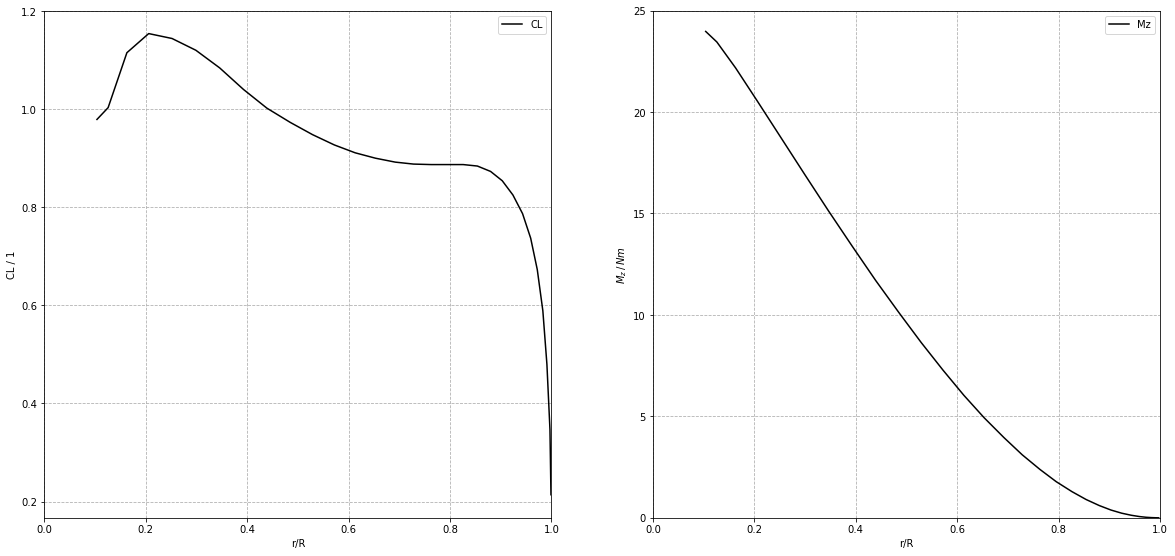

In [65]:
propeller.loadcases[0][1]['oper']

fig_oper, ax_oper = plt.subplots(1, 2, figsize=(20, 10))

propeller.loadcases[0][1]['oper'].plot(ax=ax_oper[0],
                                       x='r/R',
                                       y='CL',
                                       color='black')

ax_oper[0].set_box_aspect(1)
ax_oper[0].grid(True, which='major',linestyle='dashed')
ax_oper[0].legend()
ax_oper[0].set_ylabel('CL / 1')
ax_oper[0].set_xlim(0,1)
ax_oper[1].set_ylim(0,1.2)


propeller.loadcases[0][1]['bend'].plot(ax=ax_oper[1],
                                       x='r/R',
                                       y='Mz',
                                       color='black')

ax_oper[1].set_box_aspect(1)
ax_oper[1].grid(True, which='major',linestyle='dashed')
ax_oper[1].legend()
ax_oper[1].set_ylabel('$M_z\, / \,Nm$')
ax_oper[1].set_xlim(0,1)
ax_oper[1].set_ylim(0,25)


---

## FE-Modellierung mit PyMapdl

In [66]:
# Third-Party-imports
import pyansys
import ipywidgets as widgets
from ipywidgets import interactive, interact_manual, interact
import pyvista as pv
import itkwidgets

# Local imports
from femodel import Threepartmodel
from util_mapdl import Material

ansys_path = '/home/y0065120/Dokumente/Leichtwerk/Projects/ansys-0/'
jobname ='job-0'

mapdl = pyansys.launch_mapdl(run_location=ansys_path,
                             nproc=2,
                             override=True,
                             loglevel='error',
                             additional_switches='-smp -d X11C',
                             jobname=jobname,
                             allow_ignore=True,
                             mode='console')

femodel = Threepartmodel(mapdl,
                         mesh_density_factor=1,
                         propeller=propeller,
                         n_sec=20)

femodel.materials = {'flaxpreg': Material(mapdl, 'FLAXPREG-T-UD', 1),
                     'balsa': Material(mapdl, 'balsaholz', 2)}

femodel.element_data = pd.read_csv('./mf3218/element_data.csv', index_col=(0))

femodel.cdread()

In [79]:
solution_data = pd.read_csv('./auswertung/solution_35-03_99-70_catia_2.csv')

@interact(number=widgets.IntSlider(min=0, max=len(solution_data['F'])-1, value=len(solution_data['F'])-1, description='Iteration Number'))
def get_iteration_dataset(number):
    global_vars = list(solution_data.iloc[number, [109, 110]])
    rho = list(solution_data.iloc[number, [i*2 + 111 for i in range(14)]])
    div = list(solution_data.iloc[number, [i*2 + 112 for i in range(14)]])
        
    items = {}
    items['phi0'] =widgets.FloatSlider(value=global_vars[0],min=0.,max=180., description='phi0')
    items['phi1'] =widgets.FloatSlider(value=global_vars[1],min=0.,max=180., description='phi1')

    for i in range(14):
        items['rho' + str(i)] = widgets.FloatSlider(value=rho[i],min=0.,max=1.,step=0.01, description='rho' + str(i))
        items['div' + str(i)] = widgets.FloatSlider(value=div[i],min=0.,max=1.,step=0.01, description='div' + str(i))
    
    @interact_manual(gui=widgets.Checkbox(value=False, description='Open APDL Gui', disabled=False),**items)
    def solve_femodel(gui,**kwargs):
            global_vars = []
            global_vars.append(kwargs['phi0'])
            global_vars.append(kwargs['phi1'])
            
            args = []
            for i in range(14):
                args.append((kwargs['rho' + str(i)], kwargs['div' + str(i)]))
            for i in range(6):
                args.append((0, 0.5))
    
            femodel.clear()
            femodel.cdread()
            femodel.change_design_variables(global_vars, *args)
            femodel.__solve__()
    
            mass , i_f, i_m = femodel.post_processing()
        
            if gui:
                call('cp mf3218/plasma.cmap /tmp/ansys_tmp/', shell=True)
                mapdl.open_gui()
            
            fig3, ax3 = plt.subplots(figsize=(25.5, 12))
            
            plt.subplot(2,1,1)
            
            plt.plot(i_f, marker='x', label='i_f')
            plt.plot(i_m, marker='x', label='i_m')
            plt.xlim(0,19)
            plt.xticks(np.linspace(0,19,20))
            plt.ylim(0,1.2)
            plt.grid(True, which='major', linestyle='--')
            plt.xlabel('Section Number')
            plt.ylabel('Versagensindex nach Puck / $1$')
            plt.legend()
            
            plt.subplot(2,1,2)
            
            plt.plot([kwargs['rho' + str(i)] for i in range(14)], label='rho', marker='x')
            plt.plot([kwargs['div' + str(i)] for i in range(14)], label='div', marker='x')
            plt.xlim(0,19)
            plt.xticks(np.linspace(0,19,20))
            plt.ylim(0,1)
            plt.grid(True, which='major', linestyle='--')
            plt.ylabel('Wert der Designvariablen')
            plt.xlabel('Section Number')
            plt.legend()
            
            print('Masse: ' + str(np.round(mass*1e6,2)) + 'g')


interactive(children=(IntSlider(value=162, description='Iteration Number', max=162), Output()), _dom_classes=(…

interactive(children=(Text(value='Pressure by Lift', description='column'), Button(description='Run Interact',…

In [78]:
solution = pd.read_csv('./auswertung/solution_35-03_99-70_catia_2.csv', index_col=0)

@interact(eval=widgets.IntSlider(min=-1, max=len(solution['F'])-1, step=1, value=len(solution['F'])-1))
def plot_eval(eval):
    i_f = solution.iloc[eval, [i+1 for i in range(20)]]
    i_m = solution.iloc[eval, [i+21 for i in range(20)]]
    rho = solution.iloc[eval, [i*2+110 for i in range(14)]]
    div = solution.iloc[eval, [i*2+111 for i in range(14)]]
    
    fig, ax = plt.subplots(figsize=(25.5,15))

    plt.subplot(4, 1, 1)
    
    plt.plot(list(i_f), marker='x')
    plt.grid(True,which= 'major',linestyle= '--')
    plt.xlim(0,19)
    plt.ylim(-0.6,0.3)
    plt.xlabel('Section')
    plt.ylabel('I_f')
    plt.xticks(np.linspace(0,19,20))
    plt.plot([[-1+solution['P(0)'][eval]] for i in range(14)],linestyle= '--',color='black',linewidth=1)
    plt.plot([[1-solution['P(0)'][eval]] for i in range(14)],linestyle= '--',color='black',linewidth=1)

    
    plt.subplot(4, 1, 2)
    
    plt.plot(list(i_m), marker='x')
    plt.grid(True,which= 'major',linestyle= '--')
    plt.xlim(0,19)
    plt.ylim(-1,0.3)
    plt.xlabel('Section')
    plt.ylabel('I_m')
    plt.xticks(np.linspace(0,19,20))
    
    plt.subplot(4,1,3)
    
    plt.plot(list(rho), marker='x')
    plt.grid(True,which= 'major',linestyle= '--')
    plt.xlim(0,19)
    plt.ylim(0,1)
    plt.xlabel('Section')
    plt.ylabel('rho')
    plt.xticks(np.linspace(0,19,20))
    
    plt.subplot(4,1,4)
    
    plt.plot(list(div), marker='x')
    plt.grid(True,which= 'major',linestyle= '--')
    plt.xlim(0,19)
    plt.ylim(0.3,0.7)
    plt.xlabel('Section')
    plt.ylabel('div')
    plt.xticks(np.linspace(0,19,20))

interactive(children=(IntSlider(value=162, description='eval', max=162, min=-1), Output()), _dom_classes=('wid…